In [27]:
import uproot as ur
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['legend.frameon']=True
plt.rcParams['legend.edgecolor']='white'
import uproot,glob,ROOT

from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (10, 8)

import gc

In [28]:
db = ROOT.TDatabasePDG()

Warning in <TDatabasePDG::TDatabasePDG>: object already instantiated


In [29]:
m_K=db.GetParticle(321).Mass()
m_pi=db.GetParticle(211).Mass()
m_p=db.GetParticle(2212).Mass()

In [30]:
m_lcp=2.286
m_D0bar=1.864
m_Kstar=895.81/1000

In [31]:
#help(ROOT.TLorentzVector)
import random
r=random.Random()
nu_min=8
eBeam=10.6
m_p=0.9383
def mixed_events(df,q=f"topo==2 and nu>{nu_min}", N=-1, scale_stats=-1):
    missmass=[]
    invmass=[]
    dfq=df.query(q).reset_index(drop=True)
    n=len(dfq)
    #print(n)
    d={a:[] for a in df.columns}
    init_state=ROOT.TLorentzVector(0,0, eBeam,eBeam+m_p)
    #print(init_state.Pz(), init_state.E())
    #by default, make the mixed tuple have the same number of entries as the original
    if N==-1 and scale_stats==-1:
        N=n
    elif N==-1 and scale_stats!=-1:
        N=n*scale_stats
    N=int(N)
    comps='px py pz E'.split()
    parts='e prot K pi'.split()
    
    keys={(p,comp):f'{p}_{comp}' for comp in comps for p in parts}
    for evt in range(N):
        indices=[r.randint(0,n-1) for i in range(4)]
        vectors=[ROOT.TLorentzVector(*[dfq[keys[(p,comp)]][j] for comp in comps]) for p,j in zip(parts, indices)]
        #for p,j in zip(parts, (i1,i2, i3, i4)):
        #    vectors.append(ROOT.TLorentzVector(*[dfq[keys[(p,comp)]][j] for comp in comps]))
        vsum=vectors[1]+vectors[2]+vectors[3]
        missmass.append((init_state-vectors[0]-vsum).M())
        invmass.append((vsum).M())
    del dfq
    gc.collect()
    return pd.DataFrame({'invmass':invmass, "missmass":missmass})

# Three-prong analysis: $\Lambda_c^+\rightarrow K^-\pi^+p$

In [32]:
%%time
df_lcp=pd.read_pickle("lcp_topo.pkl")


CPU times: user 2.46 ms, sys: 1.27 s, total: 1.27 s
Wall time: 1.3 s


gauss (fixed sigma and mu) + poly
N=-28+-393
Z=-0.07
chi2/dof=1.30


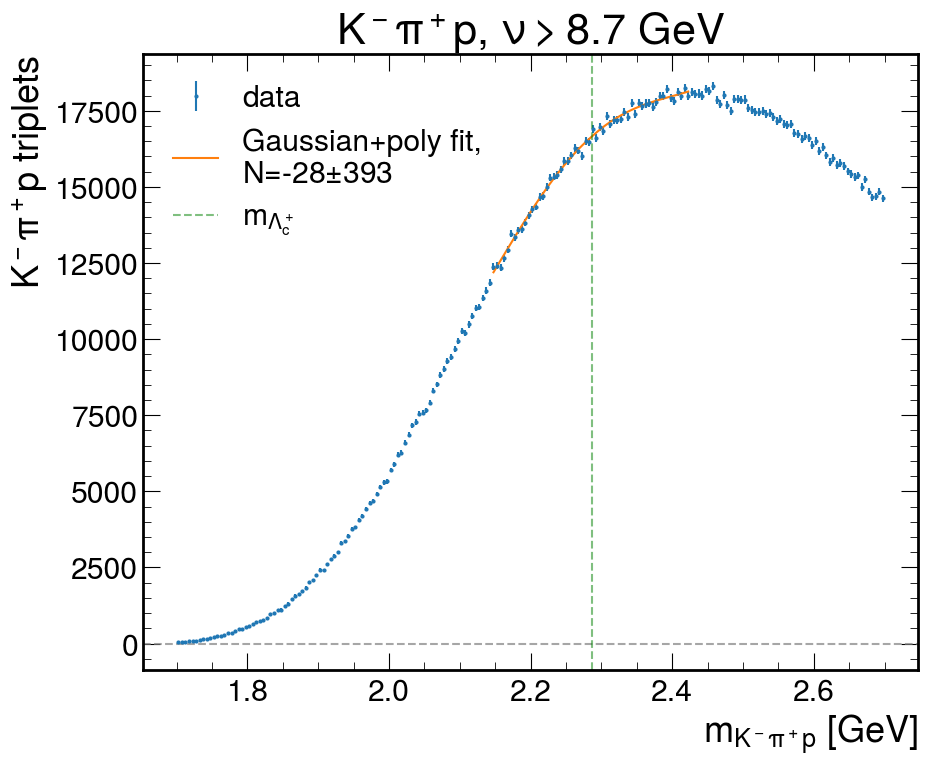

gauss (fixed sigma and mu) + poly
N=1+-45
Z=0.01
chi2/dof=0.83


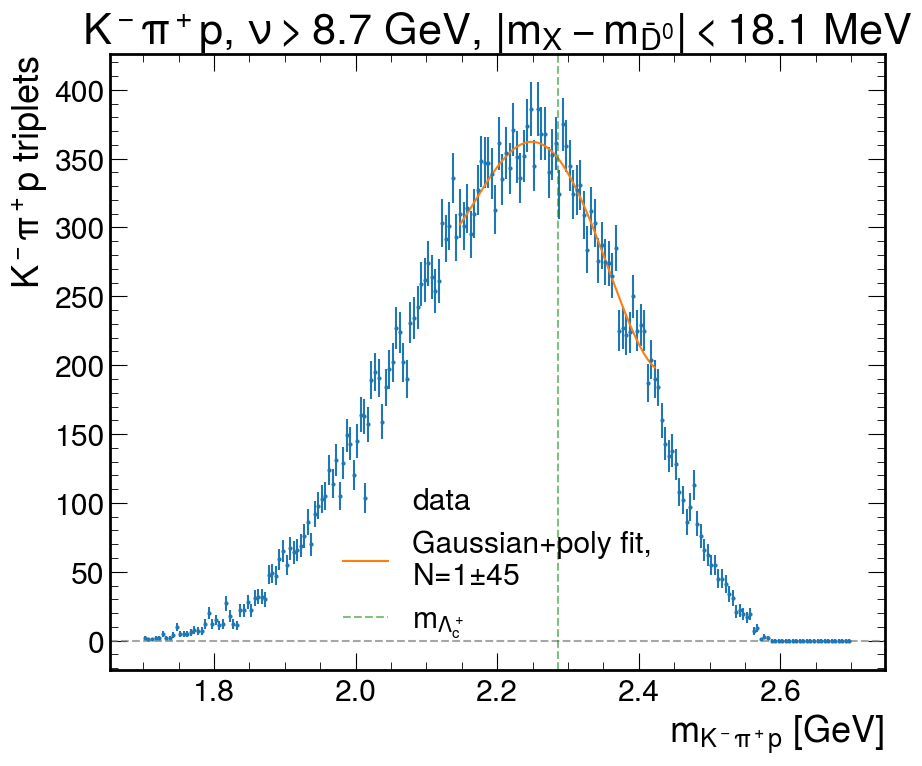

In [33]:
#search with polynomial+gaussian fit, no mixed event subtraction, no binning in nu

#for bini in range(0,len(nu_bins)-1):

for useMissMassCut in False, True:

    q=f"topo==2 and nu>={8.7}"

    dtmax_K=0.75
    dtmax_prot=0.75
    dtmax_pi=0.75
    q+=f" and abs(K_dt)<{dtmax_K}"
    q+=f" and abs(prot_dt)<{dtmax_prot}"
    q+=f" and abs(pi_dt)<{dtmax_pi}"


    K_scale=1.007
    pi_scale=1.007
    prot_scale=1.007
    xvar=f"sqrt((sqrt(K_p**2*{K_scale**2}+{m_K**2})+sqrt(pi_p**2*{pi_scale**2}+{m_pi**2})+sqrt(prot_p**2*{prot_scale**2}+{m_p**2}))**2"+\
            f"-(K_px*{K_scale}+pi_px*{pi_scale}+prot_px*{prot_scale})**2-(K_py*{K_scale}+pi_py*{pi_scale}+prot_py*{prot_scale})**2-(K_pz*{K_scale}+pi_pz*{pi_scale}+prot_pz*{prot_scale})**2)"
    df_lcp['invmass_corr']=df_lcp.eval(xvar)

    xvar=f"sqrt((nu+{m_p}-sqrt(K_p**2*{K_scale**2}+{m_K**2})-sqrt(pi_p**2*{pi_scale**2}+{m_pi**2})-sqrt(prot_p**2*{prot_scale**2}+{m_p**2}))**2"+\
            f"-(e_px+K_px*{K_scale}+pi_px*{pi_scale}+prot_px*{prot_scale})**2-(e_py+K_py*{K_scale}+pi_py*{pi_scale}+prot_py*{prot_scale})**2-(e_E+nu-e_pz-K_pz*{K_scale}-pi_pz*{pi_scale}-prot_pz*{prot_scale})**2)"
    df_lcp['missmass_corr']=df_lcp.eval(xvar)

    mXres=0.013
    if useMissMassCut:
        mX_window=1.39*mXres
    else:
        mX_window=999




    mass_range=1.7, 2.7
    bin_width=0.005
    nbins=int((mass_range[1]-mass_range[0])//bin_width)
    bins=np.linspace(*mass_range, nbins+1)

    xvar="invmass_corr"
    vals=df_lcp.query(q+f" and abs(missmass_corr-{m_D0bar})<{mX_window}").eval(xvar)
    data,x=np.histogram(vals, bins=bins)
    bcs=(x[1:]+x[:-1])/2



    c=data
    dc=np.sqrt(data)+(data==0)


    sigma=0.007
    nsigma=20 
    #fit_range=[max(m_lcp-nsigma*sigma,min(vals)), min(m_lcp+nsigma*sigma, max(vals))]
    fit_range=[m_lcp-nsigma*sigma, m_lcp+nsigma*sigma]

    #gaussian
    P0=[0, m_lcp,0.039]
    gaus = lambda x,N, mu,sigma: N*bin_width/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
    #gaussian plus polynomial
    gaus_poly=lambda x,N, mu,sigma, *c: N*bin_width/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))\
                    +sum((c[i]*x**i for i in range(len(c))))
    sigma_fixed=sigma
    mu_fixed=m_lcp

    fixed_gaus_poly=lambda x,N, *c: N*bin_width/(sigma_fixed*np.sqrt(2*np.pi))*np.exp(-(x-mu_fixed)**2/(2*sigma_fixed**2))\
                    +sum((c[i]*x**i for i in range(len(c))))


    slc=(bcs>fit_range[0])&(bcs<fit_range[1])
    failed_fit=False

    try:
        poly_order=4
        fnc=fixed_gaus_poly


        #diff,ddiff=c,dc+(c==0)
        #poly_order=5
        P0=P0+[0]*(poly_order+1)
        if fnc==fixed_gaus_poly:
            P0=[0]*(poly_order+2)
        P, cov =curve_fit(fnc,bcs[slc], c[slc], p0=P0, sigma=dc[slc])
        yfit=fnc(bcs[slc],*P)
        if fnc == gaus or fnc== gaus_poly:
            fit=P[0], np.sqrt(cov[0][0]), P[1], np.sqrt(cov[1][1]), P[2], np.sqrt(cov[2][2])
            print("gaussian"+ (f" + {poly_order}th order polynomial" if poly_order>=0   else "") + " fit:")
            print("N=%.0f+-%.0f\nmu=%.3f+-%.3f GeV\nsigma=%.3f+-%.3f GeV" %fit)
            print(f"Z={fit[0]/fit[1]:.2f}")
        else :
            print("gauss (fixed sigma and mu) + poly")
            print("N=%.0f+-%.0f"%(P[0], np.sqrt(cov[0][0])))
            print(f"Z={P[0]/np.sqrt(cov[0][0]):.2f}")
        print(f"chi2/dof={sum((c[slc]-yfit)**2/dc[slc]**2)/(len(c[slc])-(2+poly_order)):.2f}")
        failed_fit=False
    except Exception as e:
        print(e)
        print("failed_fit")
        failed_fit=True

    handles=[]
    handles.append(plt.errorbar(bcs, c, dc, label="data", color='tab:blue', ls='',marker='o', markersize=2))
    if not failed_fit:
        handles.append(plt.plot(bcs[slc], yfit, color='tab:orange',
                                label=f'Gaussian+poly fit,\nN={P[0]:.0f}$\\pm${np.sqrt(cov[0][0]):.0f}')[0])
    plt.axhline(0, color='0.5', alpha=0.7, ls='--')
    plt.xlabel("$m_{K^-\pi^+ p}$ [GeV]")
    plt.ylabel(f"$K^-\pi^+ p$ triplets")
    if useMissMassCut:
        plt.gca().set_title(f"$K^-\\pi^+p$, $\\nu>8.7$ GeV, $|m_X-m_{{\\bar D^0}}|<{mX_window*1000:.1f}$ MeV")
    else:
        plt.gca().set_title(f"$K^-\\pi^+p$, $\\nu>8.7$ GeV")
    handles.append(plt.axvline(m_lcp, color='g', ls='--', alpha=0.5, label='$m_{\\Lambda_c^+}$'))
    plt.legend(handles=handles,frameon=False)
    plt.show()
    if useMissMassCut:
        N_lcp,dN_lcp =P[0], np.sqrt(cov[0][0])
    else:
        N_lcp_noMMcut,dN_lcp_noMMcut =P[0], np.sqrt(cov[0][0])
        

In [67]:
%%time
df_D0bar=pd.read_pickle("D0bar_topo.pkl")
run_list_D0bar=list(sorted(set(df_D0bar.run_num)))
gc.collect()

CPU times: user 934 ms, sys: 1.89 s, total: 2.83 s
Wall time: 4.99 s


74810

good_run_lists/Spring2019.csv 114
good_run_lists/Fall2018_Outbending.csv 156
good_run_lists/Fall2018_Inbending.csv 178


Text(1, 0, 'run number')

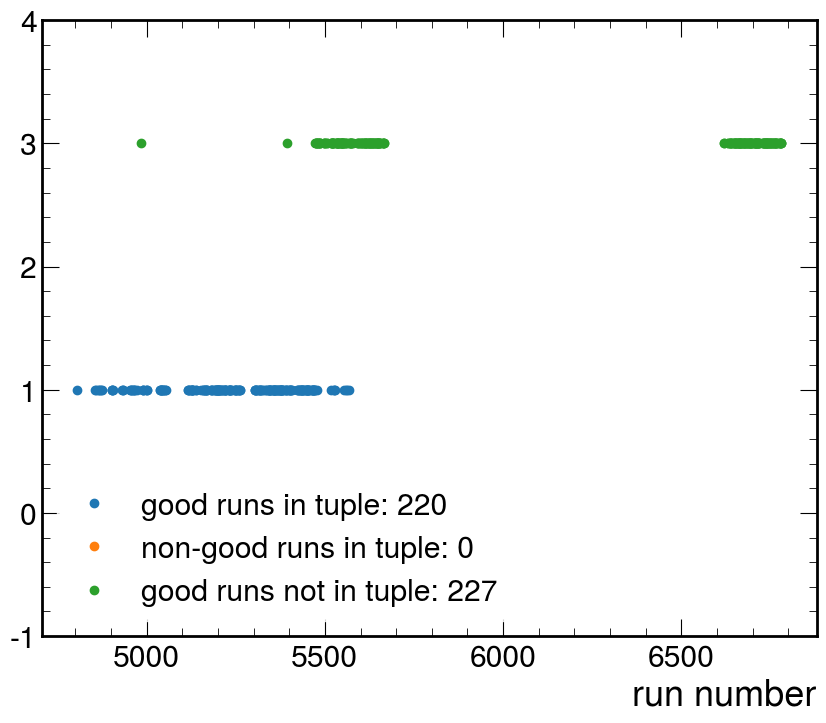

In [68]:
import glob
#help(pd.read_csv)
good_runs=[]
for f in glob.glob("good_run_lists/*"):
    df_run_period=pd.read_csv(f, names=("run","charge"))
    print(f, len(df_run_period))                              
    good_runs=np.concatenate([good_runs,df_run_period.run])

good_runs=sorted(good_runs)
#print(good_runs)
#print(run_list_D0bar)

good_runs_in_tuple=[]
good_runs_not_in_tuple=[]
not_good_runs_in_tuple=[]
for i in range(int(min(min(good_runs),min(run_list_D0bar))), int(max(max(good_runs), max(run_list_D0bar)))):
    a=i in good_runs
    b=i in run_list_D0bar
    
    if a and b:
        good_runs_in_tuple.append(i)
    elif b:
        not_good_runs_in_tuple.append(i)
    elif a:
        good_runs_not_in_tuple.append(i)
    
plt.plot(good_runs_in_tuple,[1]*len(good_runs_in_tuple), ls='', marker='o', label=f"good runs in tuple: {len(good_runs_in_tuple)}")
plt.plot(not_good_runs_in_tuple,[2]*len(not_good_runs_in_tuple), ls='', marker='o', label=f"non-good runs in tuple: {len(not_good_runs_in_tuple)}")
plt.plot(good_runs_not_in_tuple,[3]*len(good_runs_not_in_tuple), ls='', marker='o', label=f"good runs not in tuple: {len(good_runs_not_in_tuple)}")
plt.legend()
plt.ylim(-1, 4)
plt.xlabel("run number")
# for run in good_runs:
#     found =False
#     for run2 in run_list_D0bar:
#         if int(run2)==int(run):
#             found=True
#             break
#     if not found:
#         print(f"run {run} found in good run list but missing from D0bar tuple")
# print()
# for run in run_list_D0bar:
#     found =False
#     for run2 in good_runs:
#         if int(run2)==int(run):
#             found=True
#             break
#     if not found:
#         print(f"run {run} found in D0bar tuple but missing from good run list")

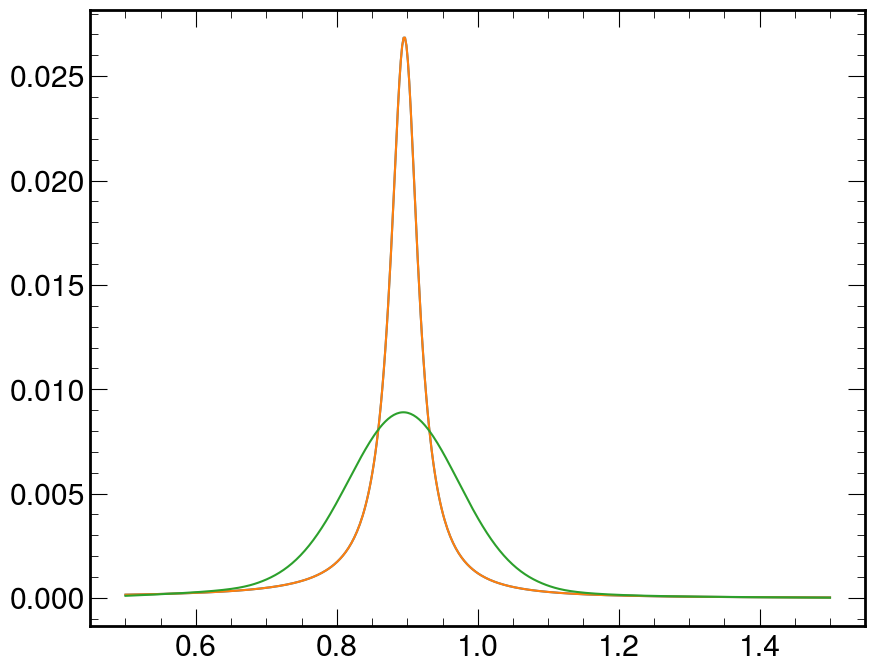

In [69]:
bin_width=0.002

def bw_poly(x, N,M,width, *c):
    width=abs(width)
    M=abs(M)
    g=M*np.hypot(M, width)
    assert M**2+g>0
    k=2*np.sqrt(2)*M*width*g/(np.pi*np.sqrt(M**2+g))
    bw=N*bin_width*k/((x*x-M**2)**2+(M*width)**2)
    poly=sum((c[i]*x**i for i in range(len(c))))
    return bw+poly

def bw_conv_gaus_fixedmean_poly(x, N, sigma, *c):
    M=m_Kstar
    width=0.0474
    g=M*np.hypot(M, width)
    assert M**2+g>0
    k=2*np.sqrt(2)*M*width*g/(np.pi*np.sqrt(M**2+g))
    bw=N*bin_width*k/((x*x-M**2)**2+(M*width)**2)
    poly=sum((c[i]*x**i for i in range(len(c))))
    
    if sigma == 0:
        return bw+poly
    else :
        #first define a window
        w=min(abs(x[-1]-x[0])/2, 3*abs(sigma))
        dx=np.linspace(-w, w, 2*int(w/bin_width)+1)
        gaus_conv=np.exp(-dx**2/(2*sigma**2))
        return np.convolve(bw,gaus_conv, mode='same')/sum(gaus_conv)+poly
def bw_conv_gaus_poly(x, N, M,width, sigma, *c):
    width=abs(width)
    M=abs(M)
    g=M*np.hypot(M, width)
    assert M**2+g>0
    k=2*np.sqrt(2)*M*width*g/(np.pi*np.sqrt(M**2+g))
    bw=N*bin_width*k/((x*x-M**2)**2+(M*width)**2)
    poly=sum((c[i]*x**i for i in range(len(c))))
    
    if sigma == 0:
        return bw+poly
    else :
        w=min(abs(x[-1]-x[0])/2, 3*abs(sigma))
        dx=np.linspace(-w, w, 2*int(w/bin_width)+1)
        gaus_conv=np.exp(-(dx)**2/(2*sigma**2))
        return np.convolve(bw,gaus_conv, mode='same')/sum(gaus_conv)+poly
x=np.linspace(0.5, 1.5, 500)

plt.plot(x, bw_poly(x, 1,m_Kstar, 0.0474))
plt.plot(x, bw_conv_gaus_fixedmean_poly(x, 1, 0))
plt.plot(x, bw_conv_gaus_fixedmean_poly(x, 1, 0.07))

Breit-Wigner + 7th order polynomial fit:
N=131079+-12976
M=0.894+-0.001 GeV
Gamma=0.050+-0.004 GeV
Z=10.10
chi2/dof=2.69


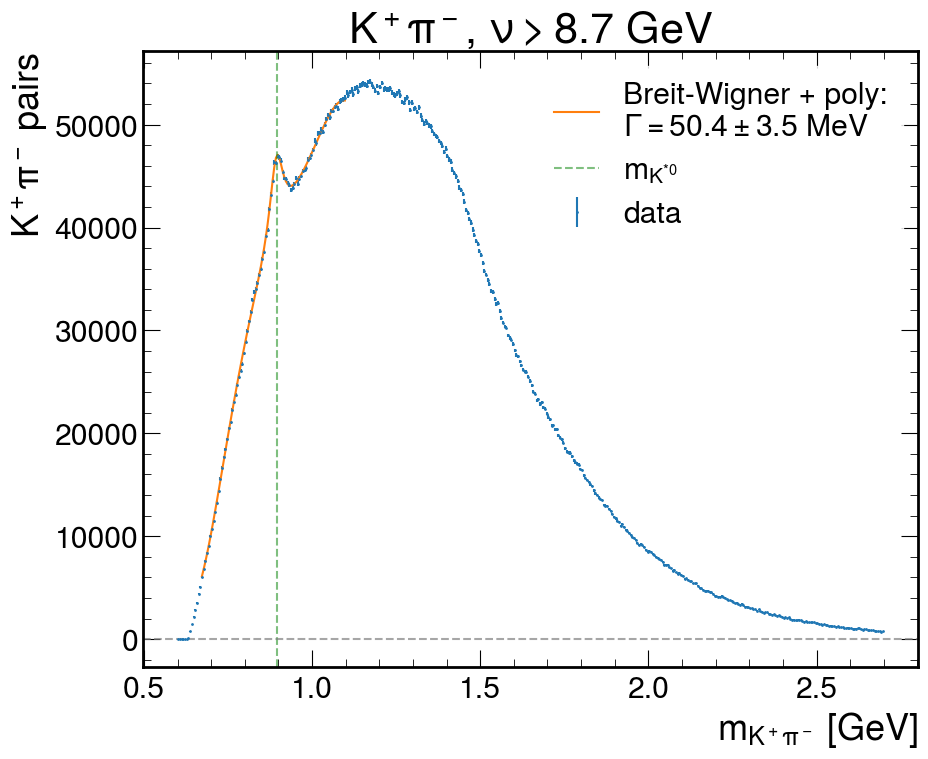

In [70]:

    
q=f"nu>8.7"

dtmax_K=0.75
dtmax_prot=0.75
dtmax_pi=0.75
q+=f" and abs(K_dt)<{dtmax_K}"
#q+=f" and abs(prot_dt)<{dtmax_prot}"
q+=f" and abs(pi_dt)<{dtmax_pi}"


# window=m_lcp  #0.08#m_D0bar

# #first plot: m_inv vs mX in nu bin for the data.  
# fig, axs=plt.subplots(1,2, figsize=(20,10))
# for i in range(2):
#     plt.sca(axs[i])
#     dfq=df_mixed_lcp if i == 0  else df_lcp.query(q)
#     lbl = ["mixed", "data"][i]
#     print(len(dfq))
#     _,_,_,h2d=axs[i].hist2d(dfq.eval("invmass"), dfq.eval("missmass"), bins=280, range=[(1,4),(0,3)],norm=colors.LogNorm())
#     plt.xlabel("$m_{K^-\pi^+p}$ [GeV]")
#     plt.ylabel("$m_{X}$ [GeV]")
#     plt.plot([m_lcp],[m_D0bar], color='r', marker='x', markersize=10)
#     axs[i].axhspan(m_D0bar-window, m_D0bar+window, facecolor='r', alpha=0.3, label='constrained')
#     plt.legend()
#     cb=fig.colorbar(h2d, label='$K^-\pi^+ p$ events')
#     axs[i].set_title(f"$m_{{\\rm inv}}$ vs $m_X$, {lbl}, nu combined")
# plt.show()


mass_range=0.60, 2.7
bin_width=0.005
nbins=int((mass_range[1]-mass_range[0])//bin_width)
bins=np.linspace(*mass_range, nbins+1)

xvar="invmass"

K_scale=1.007
pi_scale=1.007
xvar=f"sqrt((sqrt(K_p**2*{K_scale**2}+{m_K**2})+sqrt(pi_p**2*{pi_scale**2}+{m_pi**2}))**2"+\
        f"-(K_px*{K_scale}+pi_px*{pi_scale})**2-(K_py*{K_scale}+pi_py*{pi_scale})**2-(K_pz*{K_scale}+pi_pz*{pi_scale})**2)"

data,x=np.histogram(df_D0bar.query(q).eval(xvar), bins=bins)
bcs=(x[1:]+x[:-1])/2

fit_range=[0.67, 1.1]
poly_order=7

#gaussian
P0=[100000, m_Kstar,0.058]
gaus = lambda x,N, mu,sigma: N*bin_width/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
#gaussian plus polynomial
gaus_poly=lambda x,N, mu,sigma, *c: N*bin_width/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))\
                +sum((c[i]*x**i for i in range(len(c))))
#breit wigner plus polynomial
#bw_poly= lambda x,N,m,width, *c: N*2/np.pi*m**2*width*bin_width/(pow(x*x-m*m,2)+pow(m*width,2))+\
#                    +sum((c[i]*x**i for i in range(len(c))))
sigma_fixed=0.018
mu_fixed=m_Kstar

fixed_gaus_poly=lambda x,N, *c: N*bin_width/(sigma_fixed*np.sqrt(2*np.pi))*np.exp(-(x-mu_fixed)**2/(2*sigma_fixed**2))\
                +sum((c[i]*x**i for i in range(len(c))))



slc=(bcs>fit_range[0])&(bcs<fit_range[1])
failed_fit=False

plt.errorbar(bcs, data, np.sqrt(data), label="data", ls='',marker='o', markersize=1)

for fnc in  bw_poly,:#bw_conv_gaus_fixedmean_poly:
    #try:
    P0=P0+[0]*(poly_order+1)
    if fnc==fixed_gaus_poly:
        P0=[0]*(poly_order+2)
    elif fnc==bw_conv_gaus_fixedmean_poly:
        #use the N and the poly values from the previous fit here
        P0=[P[0], 0.01]+list(P[3:])
    elif fnc==bw_conv_gaus_poly:
        P0=list(P[0:3])+[0.007]+list(P[3:])
        print(P0)
    P, cov =curve_fit(fnc,bcs[slc], data[slc], p0=P0, sigma=np.sqrt(data[slc]))
    yfit=fnc(bcs[slc],*P)
    #if fnc==bw_conv_gaus_fixedmean_poly:
    if fnc== gaus_poly :
        fit=P[0], np.sqrt(cov[0][0]), P[1], np.sqrt(cov[1][1]), P[2], np.sqrt(cov[2][2])
        print("gaussian"+ (f" + {poly_order}th order polynomial" if poly_order>=0   else "") + " fit:")
        print("N=%.0f+-%.0f\nmu=%.3f+-%.3f GeV\nsigma=%.3f+-%.3f GeV" %fit)
        print(f"Z={fit[0]/fit[1]:.2f}")
    elif fnc==bw_poly:
        fit=P[0], np.sqrt(cov[0][0]), P[1], np.sqrt(cov[1][1]), P[2], np.sqrt(cov[2][2])
        print("Breit-Wigner"+ (f" + {poly_order}th order polynomial" if poly_order>=0   else "") + " fit:")
        print("N=%.0f+-%.0f\nM=%.3f+-%.3f GeV\nGamma=%.3f+-%.3f GeV" %fit)
        print(f"Z={fit[0]/fit[1]:.2f}")
    elif fnc==bw_conv_gaus_poly:
        fit=P[0], np.sqrt(cov[0][0]), P[1], np.sqrt(cov[1][1]), P[2], np.sqrt(cov[2][2])
        print("Breit-Wigner (gaus conv.)"+ (f" + {poly_order}th order polynomial" if poly_order>=0   else "") + " fit:")
        print("N=%.0f+-%.0f\nM=%.3f+-%.3f GeV\nGamma=%.3f+-%.3f GeV" %fit)
        print(f"sigma={P[3]:.3f}+-{np.sqrt(cov[3][3]):.3f}")
        print(f"Z={fit[0]/fit[1]:.2f}")
    print(f"chi2/dof={sum((data[slc]-yfit)**2/data[slc])/(len(data[slc])-len(P)):.2f}")
    failed_fit=False
    if fnc == gaus_poly:
        args={}
        args['label']=f"Gaussian + poly: $\\sigma=${P[2]:.3f} GeV"
        args['color']='tab:orange'
    elif fnc == bw_poly :
        args={}
        args['label'] = f"Breit-Wigner + poly:\n$\\Gamma={1000*abs(P[2]):.1f}\\pm{1000*np.sqrt(cov[2][2]):.1f}$ MeV"
        args['color']='tab:orange'
        args['ls']='-'
    elif fnc==bw_conv_gaus_fixedmean_poly:
        args={}
        args['label'] = f"Breit-Wigner convolved\nwith gauss + poly: $\\sigma={P[1]*1000:.2f}\\pm{np.sqrt(cov[1][1]):.2f}$ MeV"
        args['color']='tab:purple'
        args['ls']='--'
    elif fnc==bw_conv_gaus_poly:
        args={}
        args['label'] = f"poly + Breit-Wigner\nconvolved with gauss:\n"\
                         +f"$\\Gamma=${abs(P[2]):.3f}+-{np.sqrt(cov[2][2]):.3f} GeV\n$\\sigma=${P[3]:.3f}+{np.sqrt(cov[3][3]):.3f} GeV"
        args['color']='tab:purple'
        args['ls']='--'
    plt.plot(bcs[slc], yfit, **args)
#     except Exception as e:
#         print(e)
#         print("failed_fit")
#         failed_fit=True



plt.axvline(m_Kstar, color='g', ls='--', alpha=0.5, label='$m_{K^{*0}}$')    
plt.legend()
plt.axhline(0, color='0.5', alpha=0.7, ls='--')
plt.xlabel("$m_{K^+\pi^-}$ [GeV]")
plt.ylabel(f"$K^+\pi^-$ pairs")
plt.gca().set_title(f"$K^+\pi^-$, $\\nu>8.7$ GeV")
plt.show()

[1.6940000000000002, 2.0340000000000003]
[0, 0, 0, 0, 0, 0, 0]
[-2.35081104e+02  1.05350695e+07 -2.75336999e+07  2.88373189e+07
 -1.50933475e+07  3.94235529e+06 -4.10763486e+05] [[ 1.47876263e+05 -1.26033302e+09  3.29527458e+09 -3.43974258e+09
   1.79182588e+09 -4.65800316e+08  4.83422692e+07]
 [-1.26033302e+09  4.80682062e+14 -1.28995201e+15  1.38340385e+15
  -7.41132634e+14  1.98342811e+14 -2.12130376e+13]
 [ 3.29527458e+09 -1.28995201e+15  3.46208007e+15 -3.71330369e+15
   1.98955217e+15 -5.32504994e+14  5.69584006e+13]
 [-3.43974258e+09  1.38340385e+15 -3.71330369e+15  3.98319706e+15
  -2.13439403e+15  5.71335000e+14 -6.11185015e+13]
 [ 1.79182588e+09 -7.41132634e+14  1.98955217e+15 -2.13439403e+15
   1.14384016e+15 -3.06217110e+14  3.27611475e+13]
 [-4.65800316e+08  1.98342811e+14 -5.32504994e+14  5.71335000e+14
  -3.06217110e+14  8.19863228e+13 -8.77240779e+12]
 [ 4.83422692e+07 -2.12130376e+13  5.69584006e+13 -6.11185015e+13
   3.27611475e+13 -8.77240779e+12  9.38736904e+11]]
ch

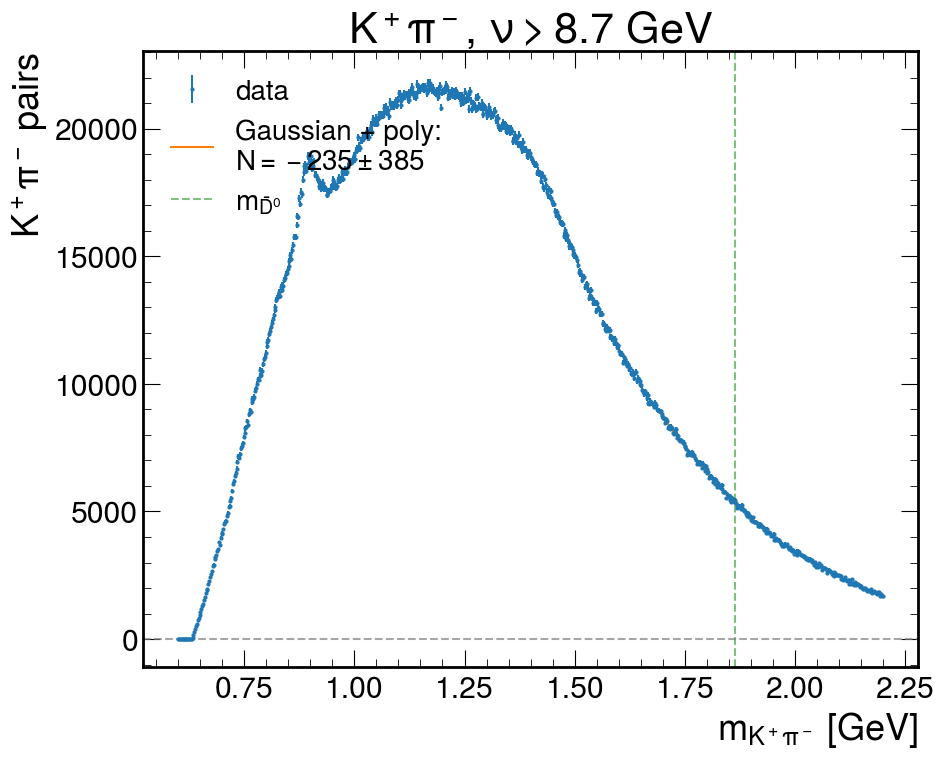

[1.6940000000000002, 2.0340000000000003]
[0, 0, 0, 0, 0, 0, 0]
[-1.61462182e+01  8.56020661e+06 -2.29510359e+07  2.45671650e+07
 -1.31220412e+07  3.49730969e+06 -3.72102410e+05] [[ 1.27756976e+04 -1.12655510e+08  2.95544404e+08 -3.09596234e+08
   1.61876626e+08 -4.22466775e+07  4.40267194e+06]
 [-1.12655510e+08  3.57293827e+13 -9.57824050e+13  1.02610768e+14
  -5.49110200e+13  1.46787206e+13 -1.56809388e+12]
 [ 2.95544404e+08 -9.57824050e+13  2.56798546e+14 -2.75135330e+14
   1.47251420e+14 -3.93672117e+13  4.20595724e+12]
 [-3.09596234e+08  1.02610768e+14 -2.75135330e+14  2.94813099e+14
  -1.57799817e+14  4.21918112e+13 -4.50821647e+12]
 [ 1.61876626e+08 -5.49110200e+13  1.47251420e+14 -1.57799817e+14
   8.44720009e+13 -2.25881657e+13  2.41381487e+12]
 [-4.22466775e+07  1.46787206e+13 -3.93672117e+13  4.21918112e+13
  -2.25881657e+13  6.04081596e+12 -6.45602144e+11]
 [ 4.40267194e+06 -1.56809388e+12  4.20595724e+12 -4.50821647e+12
   2.41381487e+12 -6.45602144e+11  6.90050073e+10]]
ch

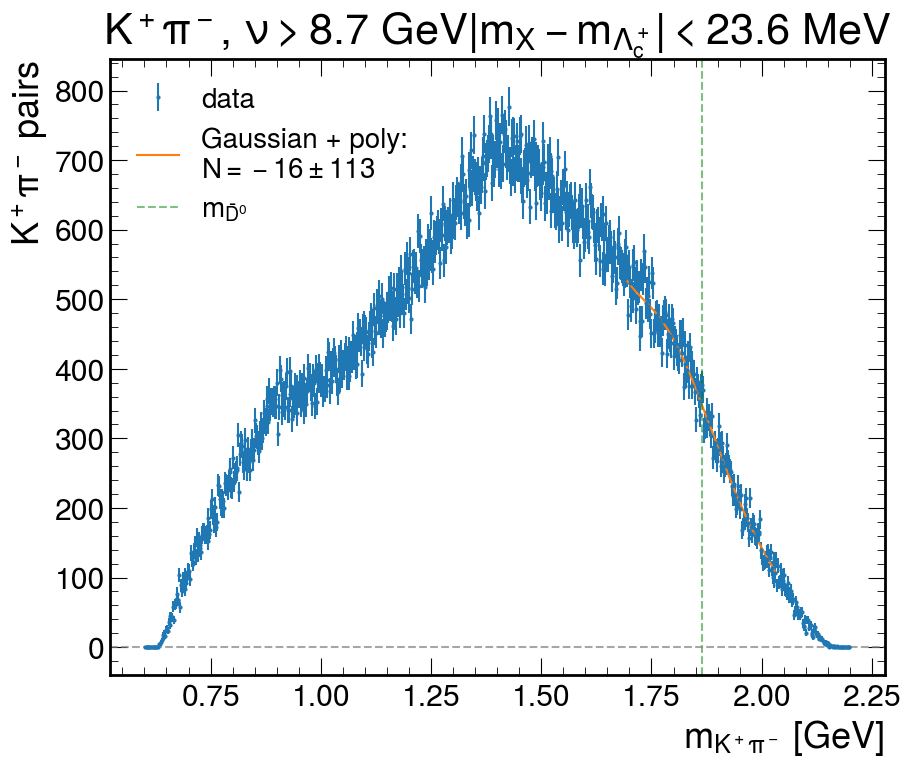

In [71]:

for useMissingMassCut in False, True:
    mX_window=1.39*0.017

    K_scale=1.007
    pi_scale=1.007
    xvar=f"sqrt((sqrt(K_p**2*{K_scale**2}+{m_K**2})+sqrt(pi_p**2*{pi_scale**2}+{m_pi**2}))**2"+\
            f"-(K_px*{K_scale}+pi_px*{pi_scale})**2-(K_py*{K_scale}+pi_py*{pi_scale})**2-(K_pz*{K_scale}+pi_pz*{pi_scale})**2)"
    df_D0bar['invmass_corr']=df_D0bar.eval(xvar)

    xvar=f"sqrt((nu+{m_p}-sqrt(K_p**2*{K_scale**2}+{m_K**2})-sqrt(pi_p**2*{pi_scale**2}+{m_pi**2}))**2"+\
            f"-(e_px+K_px*{K_scale}+pi_px*{pi_scale})**2-(e_py+K_py*{K_scale}+pi_py*{pi_scale})**2-(e_E+nu-e_pz-K_pz*{K_scale}-pi_pz*{pi_scale})**2)"
    df_D0bar['missmass_corr']=df_D0bar.eval(xvar)

    if useMissingMassCut:
        q=f"nu>8.7 and abs(missmass_corr-{m_lcp})<{mX_window}"#" and nu/y>10.3"
    else :
        q="nu>8.7"
    dtmax_K=0.75
    dtmax_prot=0.75
    dtmax_pi=0.75
    q+=f" and abs(K_dt)<{dtmax_K}"
    #q+=f" and abs(prot_dt)<{dtmax_prot}"
    q+=f" and abs(pi_dt)<{dtmax_pi}"

    mass_range=0.6, 2.2
    bin_width=0.002
    nbins=int((mass_range[1]-mass_range[0])//bin_width)
    bins=np.linspace(*mass_range, nbins+1)

    xvar="invmass_corr"
    m_K=db.GetParticle(321).Mass()
    m_pi=db.GetParticle(211).Mass()
    
    data,x=np.histogram(df_D0bar.query(q).eval(xvar), bins=bins)
    ddata=np.sqrt(data)+(data==0)
    bcs=(x[1:]+x[:-1])/2


    poly_order=5

    #gaussian
    P0=[10000, m_Kstar,0.018]
    gaus = lambda x,N, mu,sigma: N*bin_width/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
    #gaussian plus polynomial
    gaus_poly=lambda x,N, mu,sigma, *c: N*bin_width/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))\
                    +sum((c[i]*x**i for i in range(len(c))))
    #breit wigner plus polynomial
    bw_poly= lambda x,N,m,width, *c: N*2/np.pi*m**2*width*bin_width/(pow(x*x-m*m,2)+pow(m*width,2))+\
                        +sum((c[i]*x**i for i in range(len(c))))
    sigma_fixed=0.010
    mu_fixed=m_D0bar

    fixed_gaus_poly=lambda x,N, *c: N*bin_width/(sigma_fixed*np.sqrt(2*np.pi))*np.exp(-(x-mu_fixed)**2/(2*sigma_fixed**2))\
                    +sum((c[i]*x**i for i in range(len(c))))
    sigma=0.010
    nsigma=17
    fit_range=[m_D0bar-nsigma*sigma, m_D0bar+nsigma*sigma]
    print(fit_range)
    slc=(bcs>fit_range[0])&(bcs<fit_range[1])
    failed_fit=False
    handles=[]
    handles.append(plt.errorbar(bcs, data, np.sqrt(data), label="data", ls='',marker='o', markersize=2))
    for fnc in fixed_gaus_poly,:
        try:
            P0=P0+[0]*(poly_order+1)
            if fnc==fixed_gaus_poly:
                P0=[0]*(poly_order+2)
            print(P0)
            P, cov =curve_fit(fnc,bcs[slc], data[slc], p0=P0, sigma=ddata[slc])
            yfit=fnc(bcs[slc],*P)
            print(P, cov)
            #plt.plot(bcs[slc], yfit, color='tab:orange',label='fit')
            #print(f"\nbin {bini} nu in [{nu_bins[bini]} - {nu_bins[bini+1]}]")
            if fnc== gaus_poly :
                fit=P[0], np.sqrt(cov[0][0]), P[1], np.sqrt(cov[1][1]), P[2], np.sqrt(cov[2][2])
                print("gaussian"+ (f" + {poly_order}th order polynomial" if poly_order>=0   else "") + " fit:")
                print("N=%.0f+-%.0f\nmu=%.3f+-%.3f GeV\nsigma=%.3f+-%.3f GeV" %fit)
                print(f"Z={fit[0]/fit[1]:.2f}")
            elif fnc==bw_poly:
                fit=P[0], np.sqrt(cov[0][0]), P[1], np.sqrt(cov[1][1]), P[2], np.sqrt(cov[2][2])
                print("Breit-Wigner"+ (f" + {poly_order}th order polynomial" if poly_order>=0   else "") + " fit:")
                print("N=%.0f+-%.0f\nM=%.3f+-%.3f GeV\nGamma=%.3f+-%.3f GeV" %fit)
                print(f"Z={fit[0]/fit[1]:.2f}")
            print(f"chi2/dof={sum((data[slc]-yfit)**2/ddata[slc]**2)/(len(data[slc])-len(P)):.2f}")
            failed_fit=False
            if fnc == gaus_poly:
                args={}
                args['label']=f"Gaussian + poly: $\\sigma=${P[2]:.3f} GeV"
                args['color']='tab:orange'
            elif fnc == bw_poly:
                args={}
                args['label'] = f"Breit-Wigner + poly: $\\Gamma=${P[2]:.3f} GeV"
                args['color']='tab:purple'
                args['ls']='--'
            elif fnc == fixed_gaus_poly:
                args={}
                args['label']=f"Gaussian + poly:\n$N={P[0]:.0f}\\pm{np.sqrt(cov[0][0]):.0f}$"
                args['color']='tab:orange'
            handles.append(plt.plot(bcs[slc], yfit, **args)[0])
            #
            #Pnull=list(P)
            #Pnull[0]=0
            #yfit_no_gauss=fnc(bcs[slc],*Pnull)
            #plt.plot(bcs[slc], yfit, label='poly part of fit', color='tab:purple')
        except Exception as e:
            print(e)
            print("failed_fit")
            failed_fit=True
    if useMissingMassCut:
        N_D0bar,dN_D0bar=P[0],np.sqrt(cov[0][0])
    else:
        N_D0bar_noMMcut,dN_D0bar_noMMcut=P[0],np.sqrt(cov[0][0])


    handles.append(plt.axvline(m_D0bar, color='g', ls='--', alpha=0.5, label='$m_{\\bar D^{0}}$'))
    plt.axhline(0, color='0.5', alpha=0.7, ls='--')
    plt.xlabel("$m_{K^+\pi^-}$ [GeV]")
    plt.ylabel(f"$K^+\pi^-$ pairs")
    title=f"$K^+\pi^-$, $\\nu>8.7$ GeV"
    if useMissingMassCut:
        title+=f"$|m_X-m_{{\\Lambda_c^+}}|<{mX_window*1000:.1f}$ MeV"
    plt.gca().set_title(title)
    plt.legend(handles=handles,fontsize=20, loc='upper left', frameon=False)
    plt.show()

# now make the money plot

In [72]:
#first determine the beam charge of each run period

import json
run_nums=[int(a) for a in sorted(list(set(df_D0bar.run_num)))]
print(f"number of runs: {len(run_nums)}")
run_periods="rga_fa18_inbending rga_fa18_outbending rga_sp19".split()
totcharge=0
charges_qadb={}
for rp in run_periods:
    charge=0
    with open(f"/Users/spaul/clas12-qadb/qadb/pass1/{rp}/chargeTree.json") as f:
        ct=json.load(f)
        for rn in run_nums:
            strrn=str(rn)
            if strrn not in ct:
                continue
            #print(ct[strrn])
            for fn in ct[strrn]:
                if fn[-1] not in '05':
                    print("not a multiple of 5")
                charge+=(ct[strrn][fn]['fcChargeMax']-ct[strrn][fn]['fcChargeMin'])/1e6
    print(f"{rp} {charge:.0f} mC")
    charges_qadb[rp]=charge
    totcharge+=charge
print(f"total charge {totcharge:.0f} mC")

number of runs: 220
rga_fa18_inbending 37 mC
rga_fa18_outbending 10 mC
rga_sp19 0 mC
total charge 46 mC


In [73]:
#https://clasweb.jlab.org/rungroups/tlc/wiki/index.php/Main_Page#tab=Analysis
charges={}
charges["rga_fa18_inbending"]=43.4489
charges["rga_fa18_outbending"]=34.0826
charges["rga_sp19"]=50.5319
totcharge=sum([charges[a] for a in charges])
print(totcharge)

128.0634


In [74]:
#calculate the luminosity

#lumi_in_mC=129+99+60 #S18, F18, S19

Q=totcharge*1e-3 #F18, S19
density=70.8*1e-3 #g/cm^3
length=5 #cm
q_e=1.60217663e-19 #coulombs
m_H=1.6735575e-24 #grams

lumi_in_invbarns=(Q/q_e)*(density*length/m_H)/1e24
lumi_in_inv_nb=lumi_in_invbarns/1e9
#print(lumi_in_invbarns)
print(f"{lumi_in_inv_nb:.3g} nb^-1")

lumi_per_charge=1e-3/q_e*(density*length/m_H)/1e24/1e9
print(f"lumi per charge={lumi_per_charge} nb^-1/mC")

1.69e+08 nb^-1
lumi per charge=1320238.006686559 nb^-1/mC


In [75]:
((m_D0bar+m_lcp)**2-m_p**2)/(2*m_p) #8.7

8.708351865075137

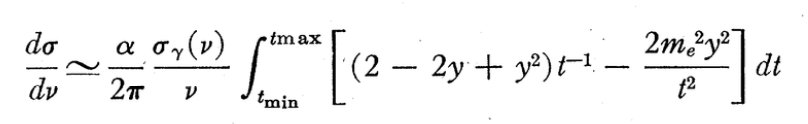

In [76]:
def mn(a,b):
    return b*(a>b)+a*(b>=a)

#Yung-Su Tsai: Pair production and bremsstrahlung of charged leptons
def e_ph_ratio(Ebeam, FT=True):
    alpha=1/137.
    #2nuM+M2=W
    threshold=((m_D0bar+m_lcp)**2-m_p**2)/(2*m_p) #8.7
    if FT:
        Ee_min=0.5
    else :
        Ee_min=0.001
    nu=np.linspace(threshold,Ebeam-Ee_min,100)
    y=nu/Ebeam
    
    me=0.000511
    
    if FT:
        thetae_max, thetae_min=np.array((4.5,2.5))*np.pi/180
        tmax=4*Ebeam**2*(1-y)*np.sin(thetae_max/2)**2
        tmin=4*Ebeam**2*(1-y)*np.sin(thetae_min/2)**2
        #print("tmax,tmin=",tmax,tmin)
    else:
        tmax=0.770**2  # rho mass^2
        tmin=me**2*y**2/(1-y)
        
    f=alpha/np.pi*((1-y+1/2*y**2)*np.log(tmax/tmin)+me**2*y**2*(1/tmax-1/tmin))/y

    integral=sum(f)*(y[1]-y[0])
    return integral
print("ratio with FT requirement:", e_ph_ratio(10.6, True))
print("ratio without FT requirement:", e_ph_ratio(10.6, False))

ratio with FT requirement: 0.000207433086486807
ratio without FT requirement: 0.0027874652921729736


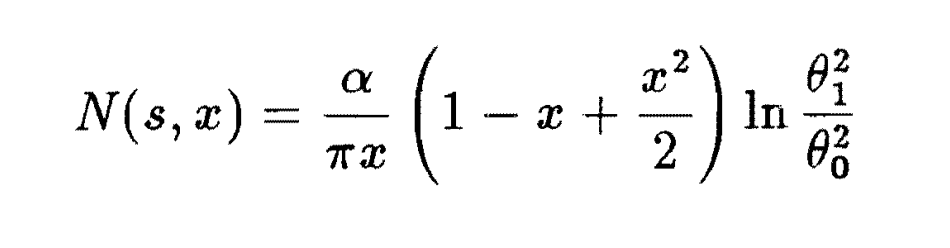

In [77]:
# https://lss.fnal.gov/archive/other/lpc-94-35.pdf

In [78]:
def e_ph_ratio_Kessler(Ebeam):
    alpha=1/137.
    #2nuM+M2=W
    threshold=((m_D0bar+m_lcp)**2-m_p**2)/(2*m_p) #8.7
    
    #specs of the CLAS12 FT
    thetamax=4.5*np.pi/180
    thetamin=2.5*np.pi/180
    Ee_min=0.5
    
    nu=np.linspace(threshold,Ebeam-Ee_min,100)
    y=nu/Ebeam
    
    f=alpha/(np.pi*y)*(1-y+1/2*y**2)*np.log(thetamax**2/thetamin**2)

    integral=sum(f)*(y[1]-y[0])
    return integral
print("ratio with FT requirement:", e_ph_ratio(10.6, True))

ratio with FT requirement: 0.000207433086486807


real photon production from Richard's thesis

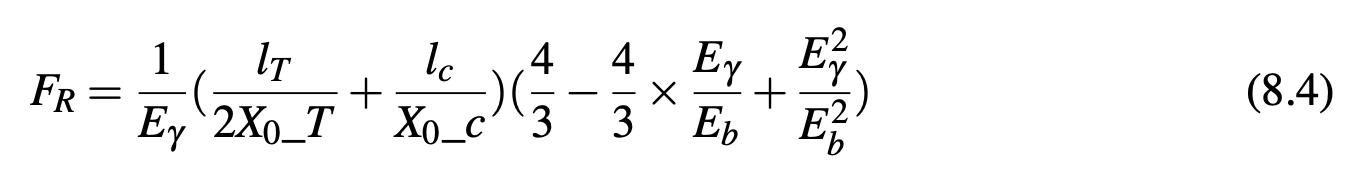

In [79]:
def e_ph_ratio_real_photons(Ebeam):
    alpha=1/137.
    #2nuM+M2=W
    threshold=((m_D0bar+m_lcp)**2-m_p**2)/(2*m_p) #8.7
    
    #specs of the CLAS12 FT
    thetamax=4.5*np.pi/180
    thetamin=2.5*np.pi/180
    Ee_min=0.5
    
    nu=np.linspace(threshold,Ebeam-Ee_min,100)
    y=nu/Ebeam
    
    density=70.8*1e-3 #g/cm^3
    length=5 #cm
    radlength= 63.0 #g cm-2
    lengthFactor=length/(2*radlength/density)
    
    f=1/y*(lengthFactor)*(4/3-4/3*y+y**2)

    integral=sum(f)*(y[1]-y[0])
    return integral
print("ratio with FT requirement:", e_ph_ratio_real_photons(10.6))

ratio with FT requirement: 0.0003947644318392776


In [80]:
density=70.8*1e-3 #g/cm^3
length=5 #cm
radlength= 63.0 #g cm-2
print(length/(radlength/density))


0.005619047619047619


In [81]:
Z_90pct=1.28
from scipy.stats import norm
print(f"gaussian cdf at {Z_90pct:.3f} is {norm.cdf(Z_90pct):.3f}")

gaussian cdf at 1.280 is 0.900


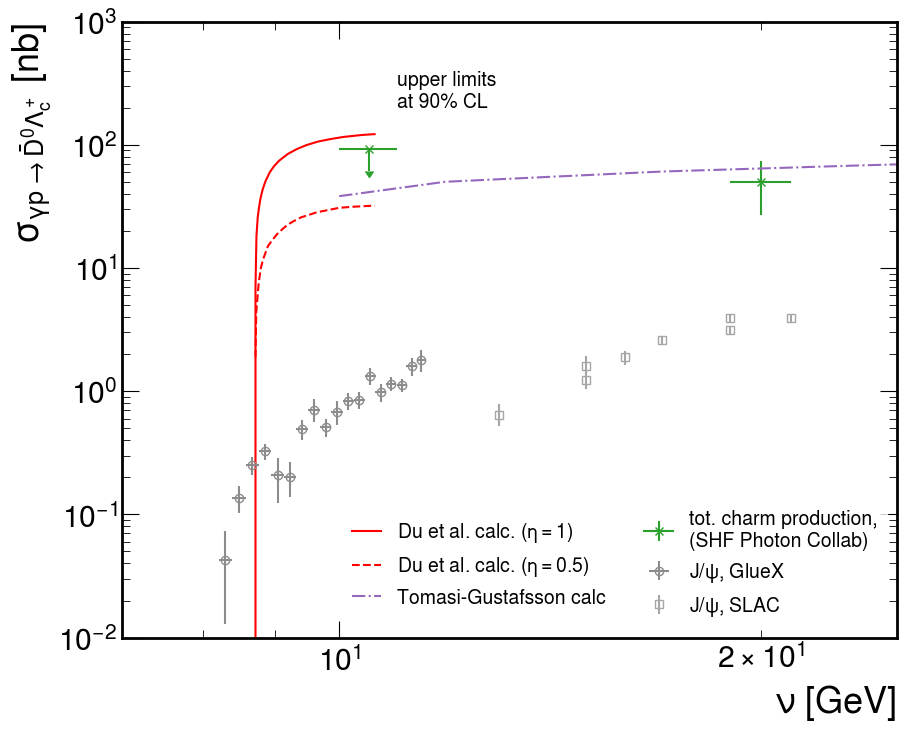

In [82]:

def plot_existing(color_slac_tot='tab:brown'):
    
    plt.ylim(1e-2, 1e3)
    plt.yscale('log')
    plt.xlabel("$\\nu$ [GeV]")
    plt.ylabel("$\\sigma_{\\gamma p\\rightarrow\\bar D^0\\Lambda_c^+}$ [nb]")
    plt.xlim(6.5, 11.5)

    #Du et al calculations:
    from io import StringIO
    import pandas as pd
    calc_str = StringIO("""nu,nb
        8.716,0.000
        8.716,6.918
        8.730,18.239
        8.748,25.786
        8.766,30.818
        8.787,36.478
        8.816,42.767
        8.858,50.314
        8.922,59.748
        8.982,66.667
        9.060,74.214
        9.191,84.277
        9.330,92.453
        9.475,99.371
        9.660,106.289
        9.858,111.321
        10.064,115.723
        10.376,120.126
        10.585,122.013
        10.599,122.013
        """)

    calc = pd.read_csv(calc_str, sep=",")
    plt.plot(calc.nu, calc.nb, label='Du et al. calc. ($\\eta=1$)', color='r')

    calc_str = StringIO("""nu,nb
        8.716,1.887
        8.727,4.403
        8.762,7.547
        8.794,10.063
        8.830,11.950
        8.897,15.094
        8.965,16.981
        9.032,18.868
        9.113,20.755
        9.199,22.642
        9.273,23.899
        9.394,25.786
        9.521,27.044
        9.635,28.302
        9.730,28.931
        10.004,30.818
        10.241,31.447
        10.585,32.075
        10.603,32.075
        """)


    calc = pd.read_csv(calc_str, sep=",")

    plt.plot(calc.nu, calc.nb, label='Du et al. calc. ($\\eta=0.5$)', color='r', ls='--')
    plt.plot()

    plt.errorbar([20], [50], [[23],[24]],[1], label='tot. charm production,\n(SHF Photon Collab)', color=color_slac_tot, marker='x')
    plt.errorbar([10.5], [92], [92/3],[0.5], uplims=[1], color=color_slac_tot, marker='x')


    gluex_str = StringIO("""nu,nb,low,up
        8.297,0.043,0.013,0.074
        8.483,0.136,0.102,0.171
        8.669,0.251,0.207,0.292
        8.855,0.327,0.278,0.376
        9.041,0.207,0.123,0.288
        9.227,0.200,0.138,0.264
        9.407,0.491,0.401,0.580
        9.593,0.710,0.565,0.859
        9.779,0.510,0.427,0.594
        9.965,0.683,0.530,0.837
        10.151,0.837,0.701,0.963
        10.337,0.848,0.719,0.987
        10.523,1.322,1.121,1.539
        10.703,0.987,0.816,1.150
        10.890,1.150,1.013,1.305
        11.081,1.121,0.987,1.257
        11.262,1.599,1.339,1.862
        11.448,1.792,1.445,2.141
        """)

    plt.plot([10.0, 11.9, 17.0, 23.6, 30.2], [38.3, 50.1, 60.7, 68.1, 73.6], color='tab:purple', ls='-.',
             label='Tomasi-Gustafsson calc')


    gluex = pd.read_csv(gluex_str, sep=",")

    dx=(gluex.nu[1]-gluex.nu[0])/2
    plt.errorbar(gluex.nu, gluex.nb, [gluex.nb-gluex.low, gluex.up-gluex.nb],dx,
                 label='$J/\\psi$, GlueX', color='0.55', ls='', marker='o', fillstyle='none')

    slac_jpsi_str= StringIO("""nu,nb,low,up
        13,0.637,0.519,0.782
        15,1.599,1.357,1.923
        15,1.224,1.039,1.503
        16,1.881,1.629,2.113
        17,2.609,2.354,2.832
        19,3.921,3.612,4.170
        19,3.129,2.882,3.327
        21,3.950,3.676,4.244
    """)
    slac_jpsi = pd.read_csv(slac_jpsi_str, sep=",")

    plt.errorbar(slac_jpsi.nu, slac_jpsi.nb, [slac_jpsi.nb-slac_jpsi.low, slac_jpsi.up-slac_jpsi.nb],
                 label='$J/\\psi$, SLAC', color='0.65', ls='', marker='s', fillstyle='none')

    plt.text(11, 2e2, "upper limits\nat 90% CL", fontsize=14)

    plt.xlim(7, 25)
    plt.xscale('log')

    plt.legend(fontsize=14, loc='lower right',ncol=2)
plot_existing('tab:green')
plt.savefig("images/existing_data.pdf")

integral at 10.6 GeV 0.000207433086486807
integral at 10.2 GeV 0.00015028614816543038
integral for combined dataset 0.00018488376035176787
ULs 27.919641637856007 35.48609151487247 21.84715390994186


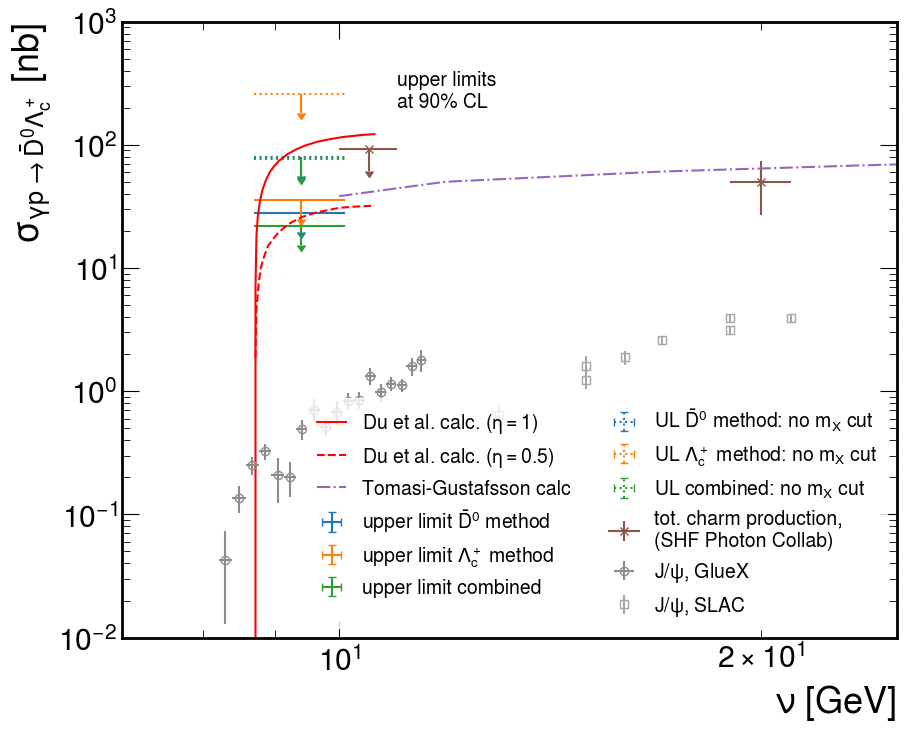

In [84]:
eff_missmass=0.84
eff_electron=0.63


#D0bar to K+pi-
branching_ratio=  0.03947#± 0.00030
eff_e_Kp_pim=0.005
correction=branching_ratio*eff_missmass*eff_e_Kp_pim
Ncorr_D0bar=N_D0bar/correction
dNcorr_D0bar=dN_D0bar/correction

#lcp
branching_ratio= 0.0626# ± 0.0029
eff_e_Km_pip_p=0.001
correction=branching_ratio*eff_missmass*eff_e_Km_pip_p
Ncorr_lcp=N_lcp/correction
dNcorr_lcp=dN_lcp/correction

#D0bar to K+pi- no MM cut
branching_ratio=  0.03947#± 0.00030
eff_e_Kp_pim=0.005
correction=branching_ratio*eff_e_Kp_pim
Ncorr_D0bar_noMMcut=N_D0bar_noMMcut/correction
dNcorr_D0bar_noMMcut=dN_D0bar_noMMcut/correction

#lcp no MM cut
branching_ratio= 0.0626# ± 0.0029
eff_e_Km_pip_p=0.001
correction=branching_ratio*eff_e_Km_pip_p
Ncorr_lcp_noMMcut=N_lcp_noMMcut/correction
dNcorr_lcp_noMMcut=dN_lcp_noMMcut/correction



# photoproduction to electroproduction

integral_10pt6=e_ph_ratio(10.6)
integral_10pt2=e_ph_ratio(10.2)

f_10pt6=(charges["rga_fa18_inbending"]+charges["rga_fa18_outbending"])/totcharge
integral=integral_10pt6*f_10pt6+integral_10pt2*(1-f_10pt6)

print("integral at 10.6 GeV",integral_10pt6)
print("integral at 10.2 GeV",integral_10pt2)
print("integral for combined dataset",integral)


UL_D0bar=(max(0,Ncorr_D0bar)+Z_90pct*dNcorr_D0bar)/lumi_in_inv_nb/integral
UL_lcp=(max(0,Ncorr_lcp)+Z_90pct*dNcorr_lcp)/lumi_in_inv_nb/integral

UL_D0bar_noMMcut=(max(0,Ncorr_D0bar_noMMcut)+Z_90pct*dNcorr_D0bar_noMMcut)/lumi_in_inv_nb/integral
UL_lcp_noMMcut=(max(0,Ncorr_lcp_noMMcut)+Z_90pct*dNcorr_lcp_noMMcut)/lumi_in_inv_nb/integral

Ncorr_combined=(Ncorr_D0bar/dNcorr_D0bar**2+(Ncorr_lcp)/dNcorr_lcp**2)/(1/dNcorr_D0bar**2+1/dNcorr_lcp**2)
dNcorr_combined=1/np.sqrt(1/dNcorr_D0bar**2+1/dNcorr_lcp**2)
UL_combined=(max(0,Ncorr_combined)+Z_90pct*dNcorr_combined)/lumi_in_inv_nb/integral
print("ULs", UL_D0bar, UL_lcp, UL_combined)

Ncorr_combined_noMMcut=(Ncorr_D0bar_noMMcut/dNcorr_D0bar_noMMcut**2+(Ncorr_lcp_noMMcut)/dNcorr_lcp_noMMcut**2)/(1/dNcorr_D0bar_noMMcut**2+1/dNcorr_lcp_noMMcut**2)
dNcorr_combined_noMMcut=1/np.sqrt(1/dNcorr_D0bar_noMMcut**2+1/dNcorr_lcp_noMMcut**2)
UL_combined_noMMcut=(max(0,Ncorr_combined_noMMcut)+Z_90pct*dNcorr_combined_noMMcut)/lumi_in_inv_nb/integral

#8.7-10.1
plt.errorbar([9.4], [UL_D0bar],[UL_D0bar*0.3], [0.7],uplims=[1],ls='', label='upper limit $\\bar D^0$ method')
plt.errorbar([9.4], [UL_lcp],[UL_lcp*0.3],[0.7],uplims=[1],ls='', label='upper limit $\\Lambda_c^+$ method')
plt.errorbar([9.4], [UL_combined], [UL_combined*0.3], [0.7],ls='',uplims=[1], label='upper limit combined')

noMMcut_errorbars=[plt.errorbar([9.4], [UL_D0bar_noMMcut],[UL_D0bar_noMMcut*0.3], [0.7],uplims=[1],ls='', label='UL $\\bar D^0$ method: no $m_X$ cut', color='tab:blue'),
                    plt.errorbar([9.4], [UL_lcp_noMMcut],[UL_lcp_noMMcut*0.3],[0.7],uplims=[1],ls='', label='UL $\\Lambda_c^+$ method: no $m_X$ cut', color='tab:orange'),
        plt.errorbar([9.4], [UL_combined_noMMcut], [UL_combined_noMMcut*0.3], [0.7],ls='',uplims=[1], label='UL combined: no $m_X$ cut', color='tab:green')]
#make these have dotted appearance
for a in noMMcut_errorbars:
    a[-1][0].set_linestyle(':')
#plt.axvspan(8.7,10.1, color='y', alpha=0.5, label='CLAS12 sensitivity')
plot_existing()
plt.savefig("images/moneyplot.pdf")

In [22]:
gc.collect()

20526

In [21]:
from scipy.stats import norm
norm.cdf(1.289)

0.9013009567105854